# Autoxidation reactions at daytime and nightime OH concentrations

This notebook examines the effect of including autoxidation reactions in the mechanism for aerosol oxidation by OH radicals at atmospheric conditions. Several properties are plotted as a function of diffusion coefficient and oxidant concentration. The diffusion coefficient is increased by an order of magnitude for each model scenario. The number after D indicates the negative base 10 logarithm of the diffusion coefficient for that scenario. The oxidant concentration is indicated by the condition where  day corresponds to daytime conditions ($5 \times 10^{6}$ molecules cm$^{-3}$) and night corresponds to nighttime conditions ($10^{5}$ molecules cm$^{-3}$). The data is first loaded in and processed, and then panel plots of each condition are produced. See Postprocesing.ipynb for a more detailed explanation of the data processing.

In [31]:
%%HTML 
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>

In [8]:
# Import modules

import warnings
warnings.filterwarnings('ignore')
import os
import zipfile

import StackSim
import numpy as np
import pandas as pd
from matplotlib import ticker
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re
import natsort



In [2]:
# Create subdirectory for data if it does not exist

subdir = os.path.join(os.path.curdir, "daynight_data")

if not os.path.isdir(subdir):
    os.mkdir(subdir)
 

# Unzip XML files (.zip file available on Github repository)

with zipfile.ZipFile("daynight.zip", "r") as zip_ref:
    zip_ref.extractall(subdir)


In [3]:

diffusion = ["D15", "D16", "D17", "D18"]
condition = ["day", "night"]
mechanism = ["", "ao_"]

# Generate filename strings

files = dict()

for cond in condition:
    for coefficient in diffusion:
        for mech in mechanism:
            filename = "tri_"+cond+"_"+mech+coefficient+".xml"
            files[cond+"_"+mech+coefficient] = filename

# Convenience function - see StackSim.py or Postprocessing.ipynb for details on how the simulation data is processed.

Scenarios = StackSim.ProcessTriSimulation(files, subdir)

## Simulation data plots

After processing the data, plots showing several different variables at different oxidant and diffusion coefficients are generated.

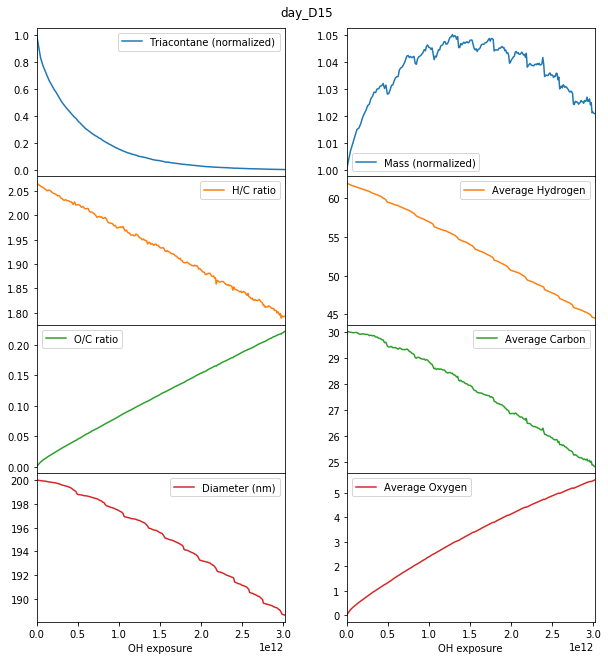

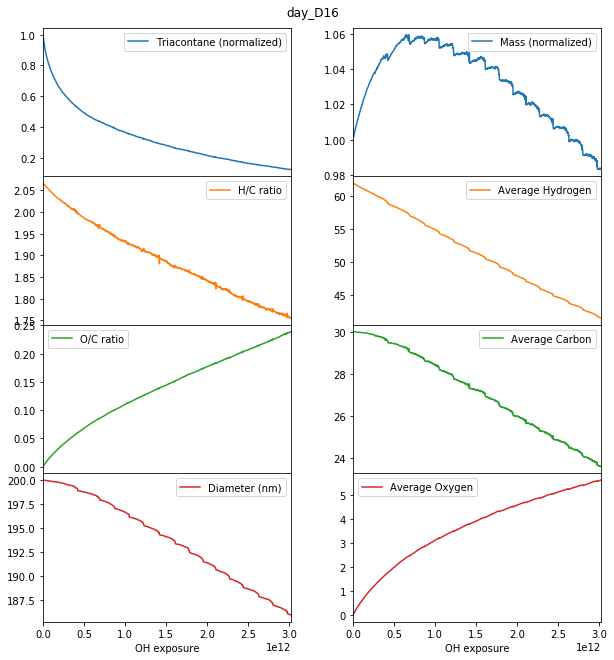

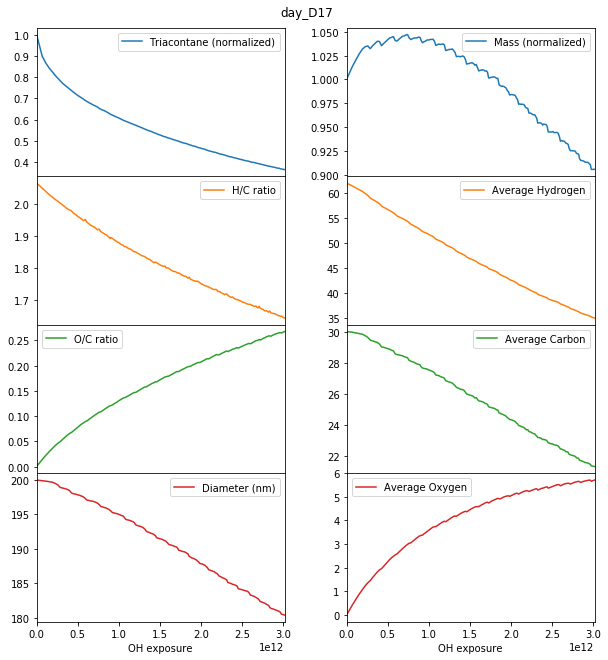

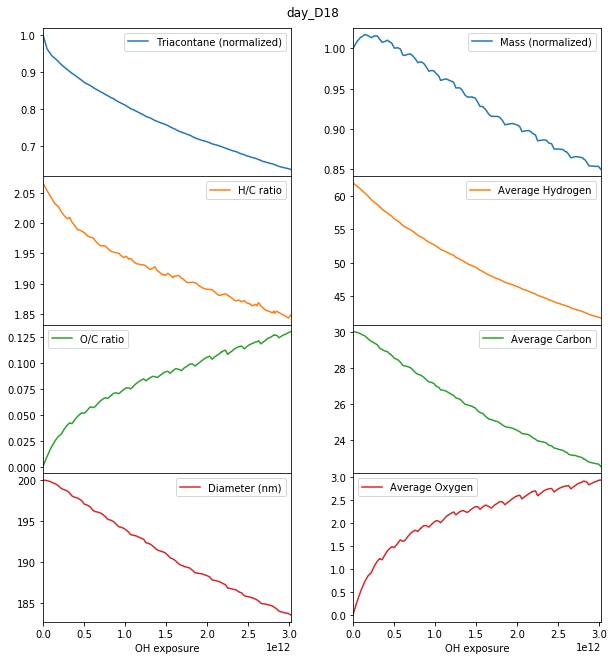

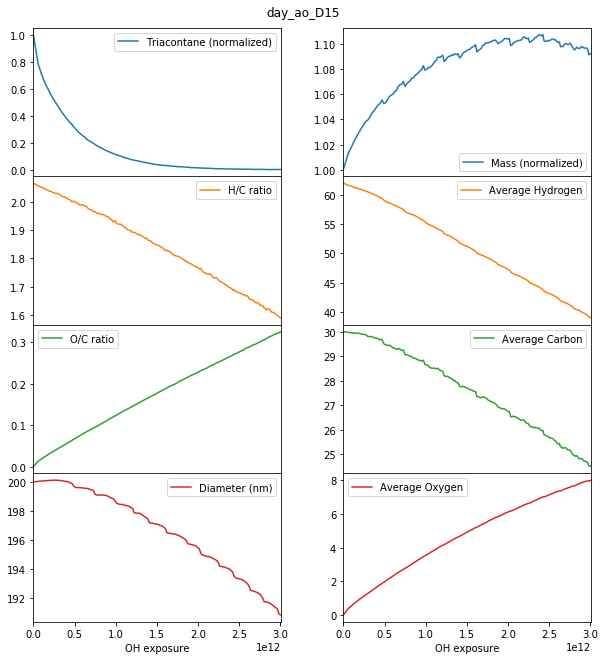

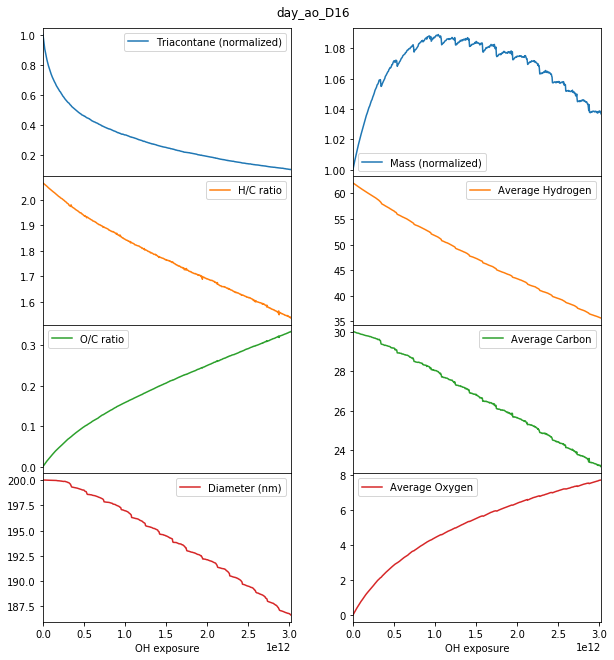

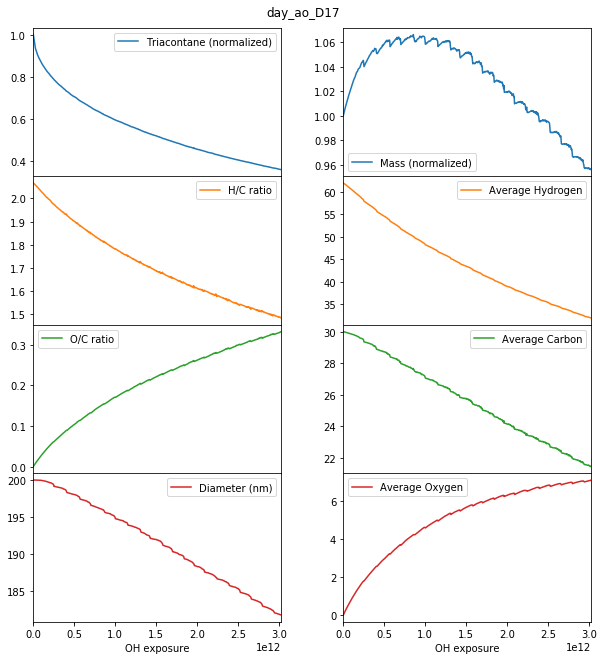

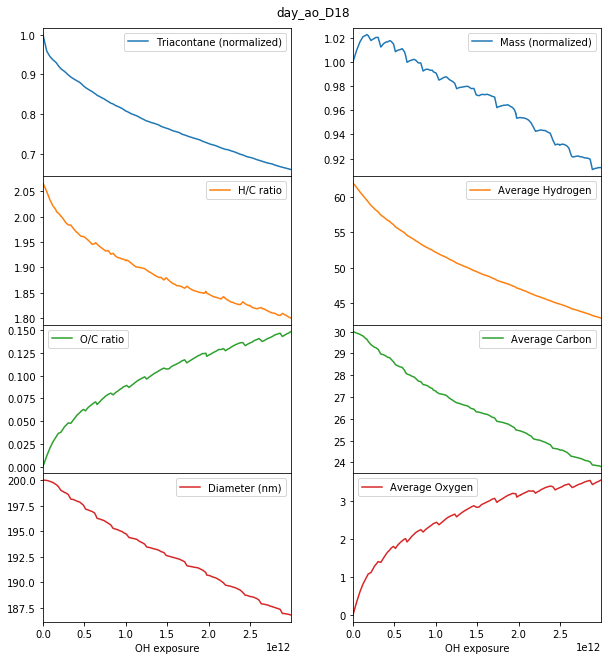

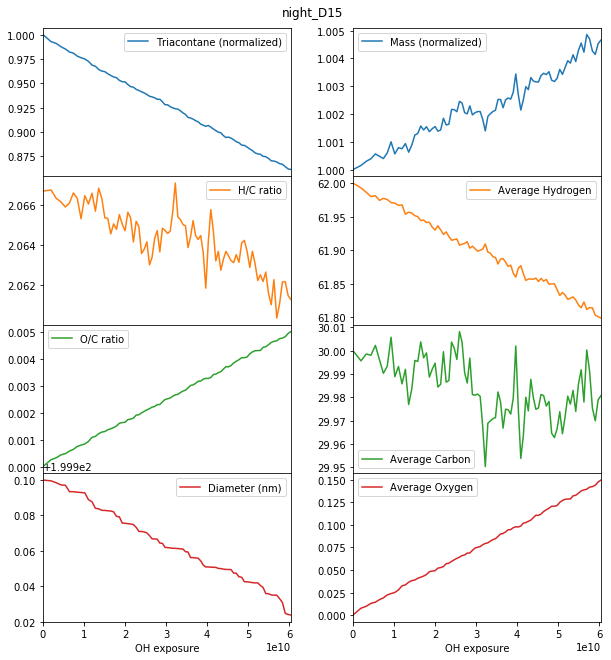

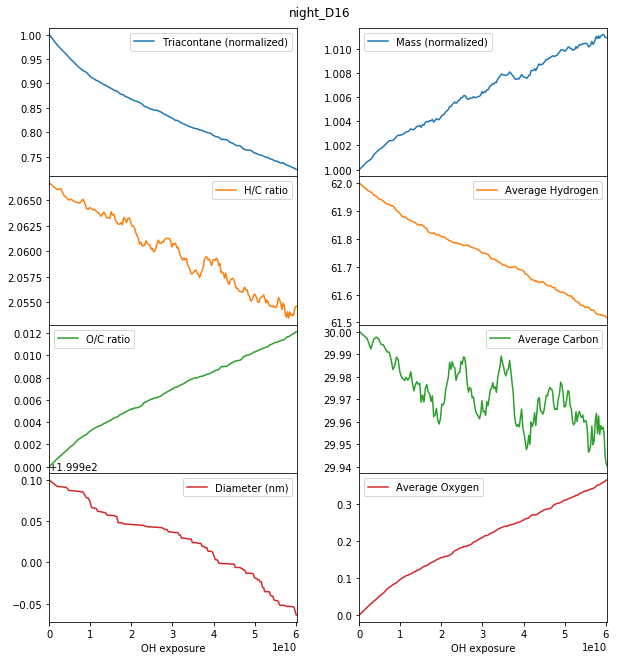

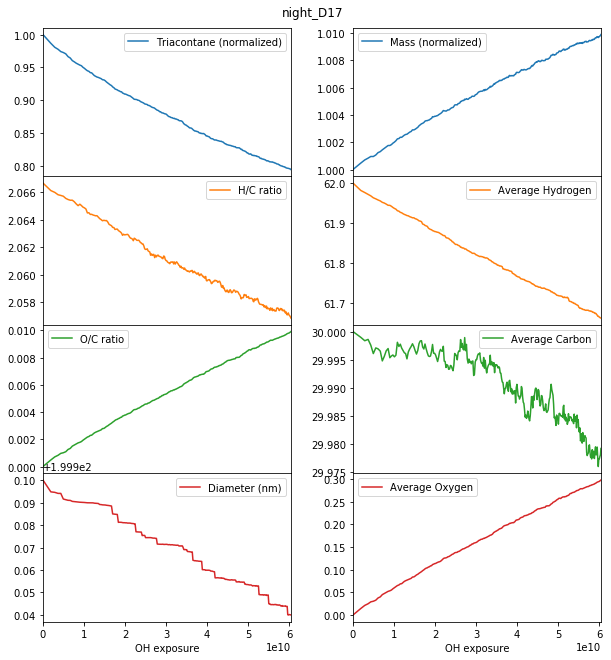

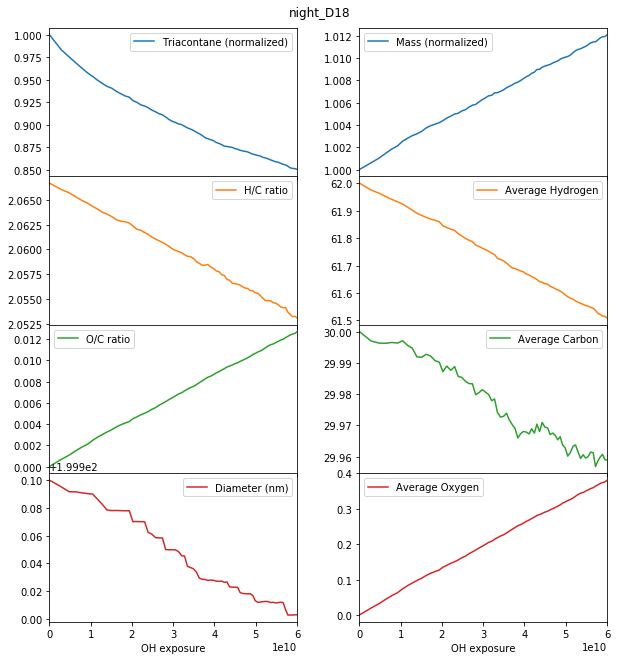

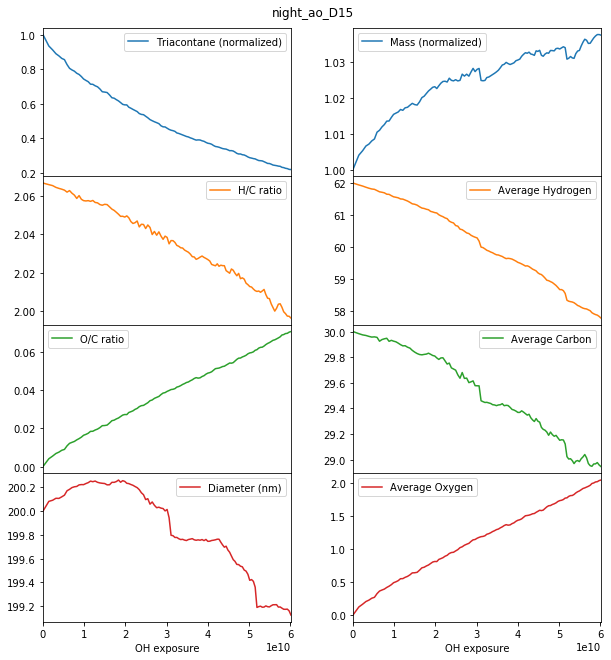

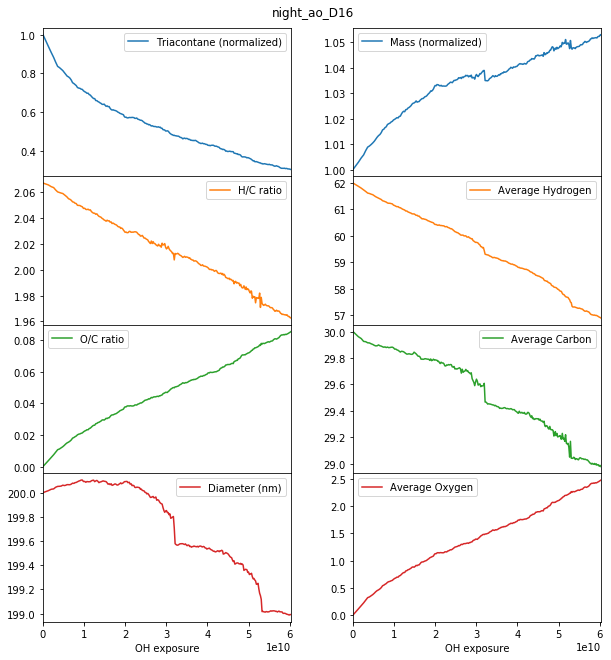

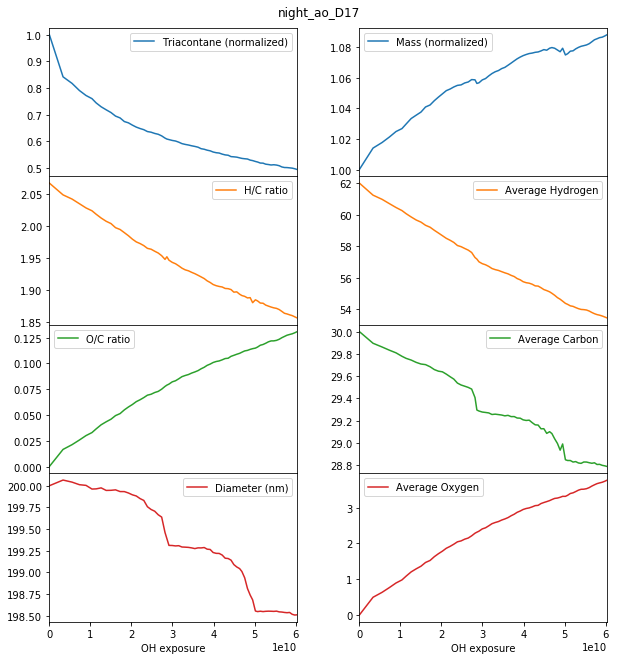

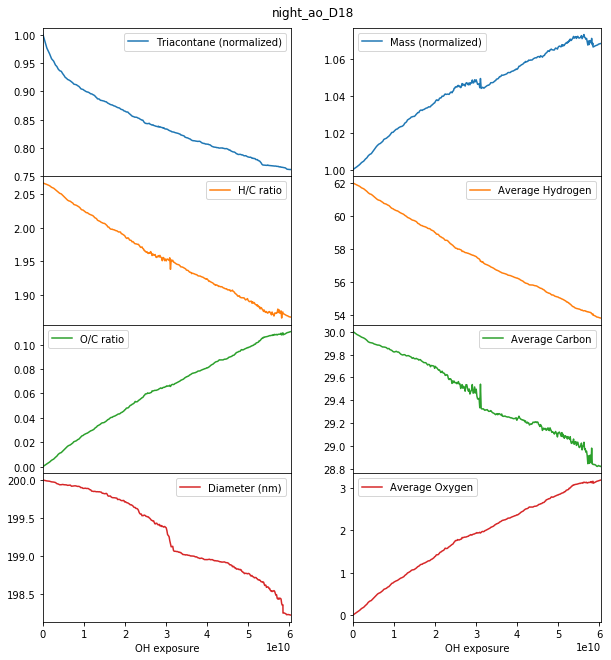

In [4]:
%matplotlib inline



# Create empty dictionary to hold scenario data frames and panels
ScenarioData = dict()

for scenario in natsort.natsorted(files.keys()):
    # Create reference to current simulation to save on typing
    simulation = Scenarios[scenario]
    
    # Find OH exposure
    if "day" in scenario:
        OH = 5E6
    else:
        OH = 1E5
    
    OH_exp = OH*simulation.time
    
    # Initialize data frame with OH exposure
    SimData = pd.DataFrame({"OH exposure" : OH_exp})
        
    # Find diameter of particle
    last_cmpt = simulation.compartments[(0, simulation.num_rows-1, 0)]
    diameter = 2*(last_cmpt.positions["y"]+last_cmpt.dimensions["y"])/1E-7
    

    
    # Find initial mass and carbon amount to normalize quantities
    tri_init = simulation.species["Tri_r"][0]
    mass_init = simulation.species["mass_r"][0]
    carbon_init = simulation.species["carbon_r"][0]
    
    # Add average data to data frame
    new_data = {"Triacontane (normalized)" : simulation.species["Tri_r"]/tri_init,
                "Mass (normalized)" : simulation.species["mass_r"]/mass_init,
                "Diameter (nm)" : diameter, 
                "Average Hydrogen" : simulation.species["hydrogen_r"]/carbon_init*30, 
                "Average Carbon" : simulation.species["carbon_r"]/carbon_init*30, 
                "Average Oxygen" : simulation.species["oxygen_r"]/carbon_init*30, 
                "H/C ratio" : simulation.species["H/C ratio"], 
                "O/C ratio" : simulation.species["O/C ratio"]}

    SimData = SimData.assign(**new_data)

    # Generate carbon list
    
    carbon_list = ["nC"+str(i) for i in range(2, 31)]
    
    # Add carbon number data to data frame
    for carbon in carbon_list:
        carbondata = {carbon : simulation.species[carbon+"_r"]}
        SimData = SimData.assign(**carbondata)

    
    # Create plot of averages
    fig, axes = plt.subplots(4, 2, figsize=(10, 10), sharex=True)
    
    fig.suptitle(scenario)
    fig.subplots_adjust(top=0.95)
    
    plt.subplots_adjust(wspace=0.25, hspace=0)
    
    target1 = [axes[0, 0], axes[1, 0], axes[2, 0], axes[3, 0]]
    target2 = [axes[0, 1], axes[1, 1], axes[2, 1], axes[3, 1]]
    
    SimData.plot(ax = target1, x = "OH exposure", 
                 y = ["Triacontane (normalized)", "H/C ratio", "O/C ratio", "Diameter (nm)"],
                 subplots = True, sharex = False)
    
    SimData.plot(ax = target2, x = "OH exposure",
                 y = ["Mass (normalized)", "Average Hydrogen", "Average Carbon", "Average Oxygen"],
                 subplots = True, sharex = False)
    
    ScenarioData[scenario+" averages"] = SimData

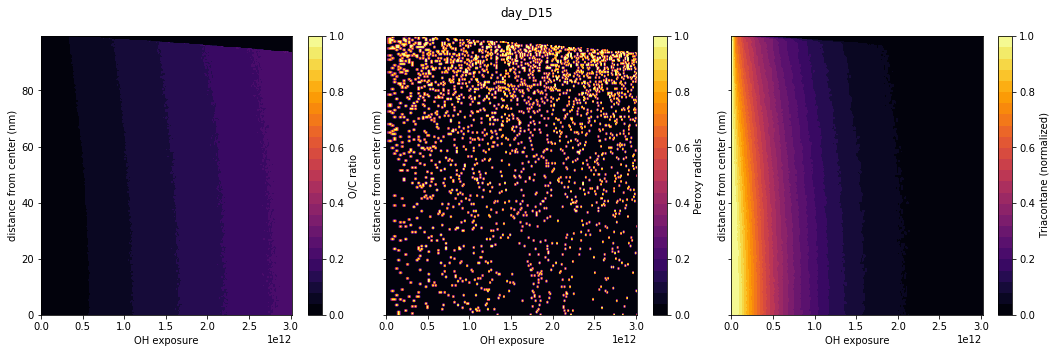

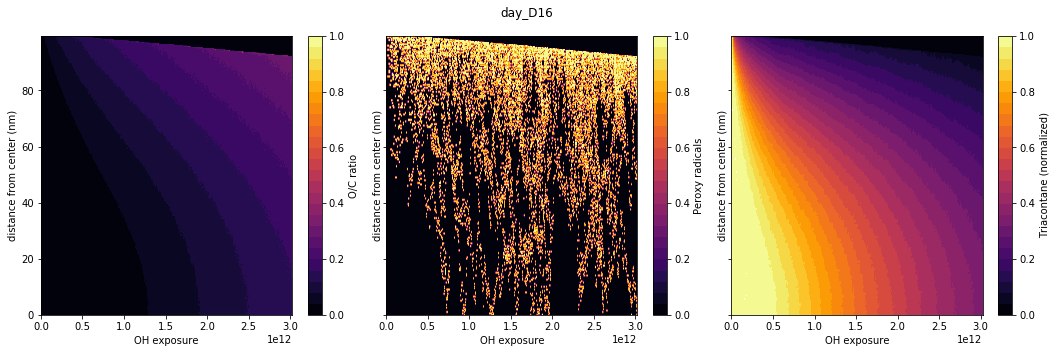

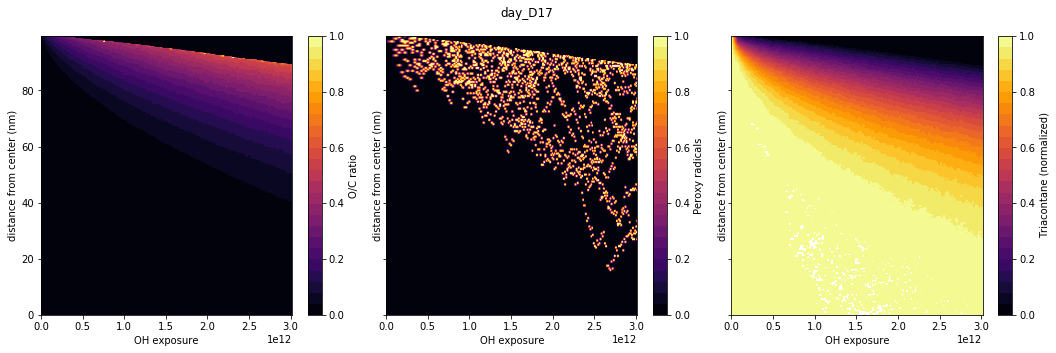

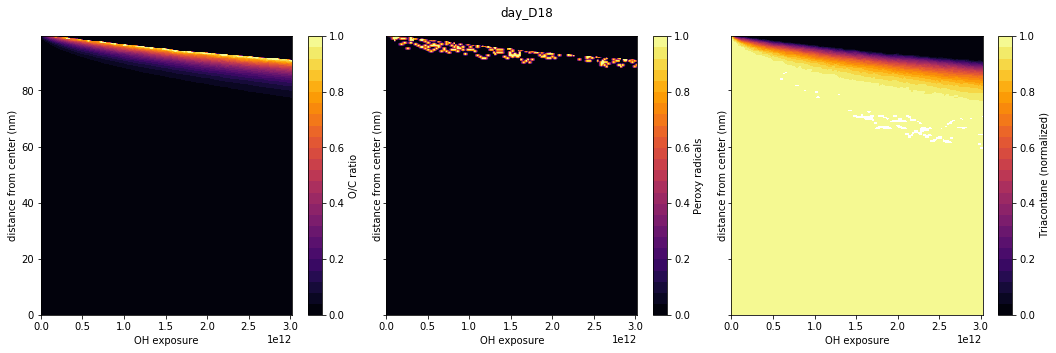

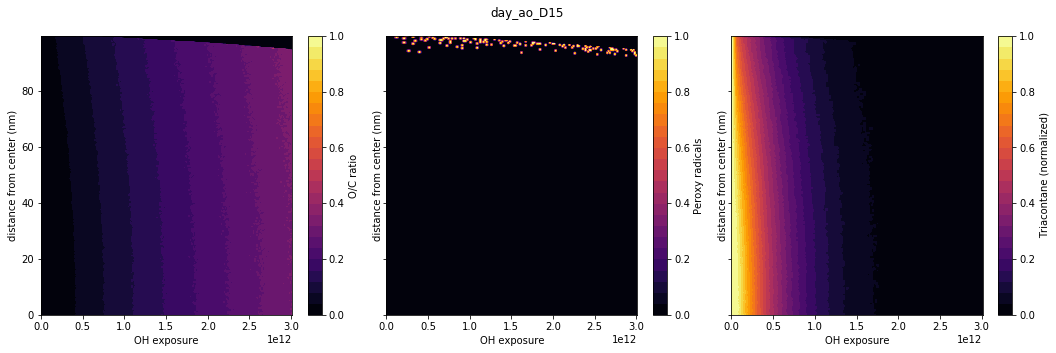

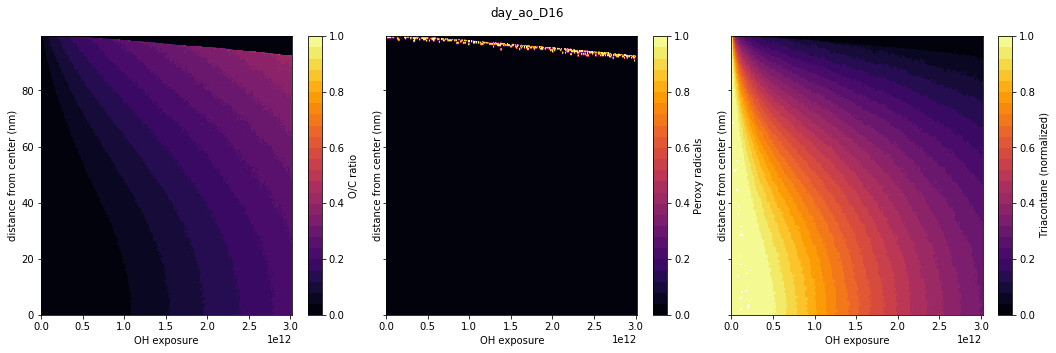

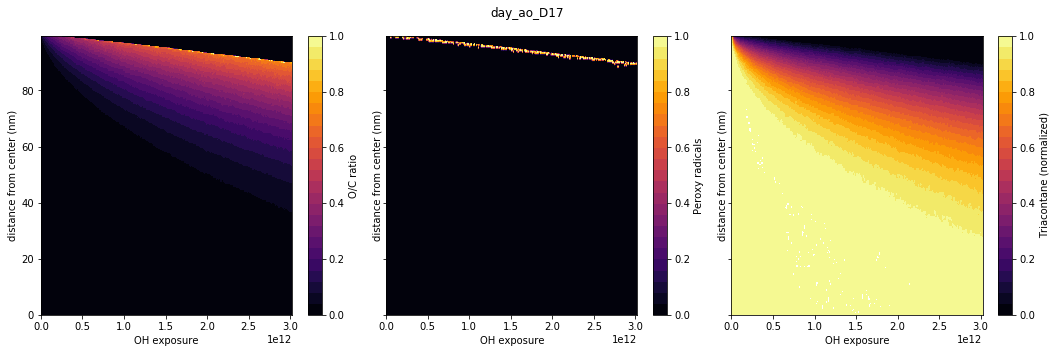

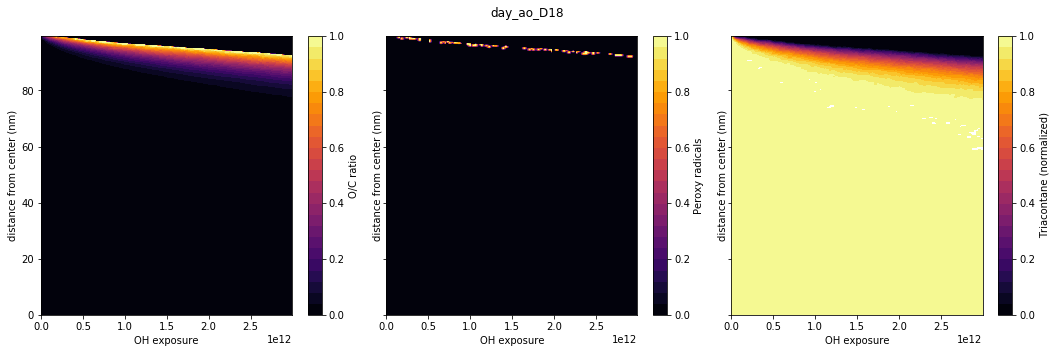

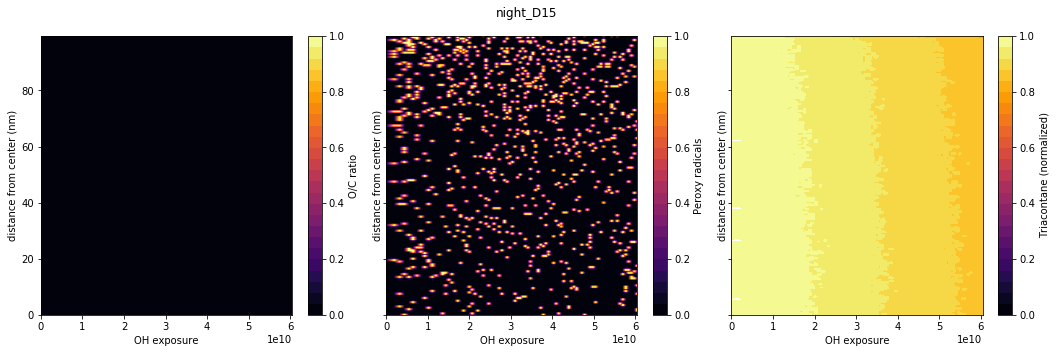

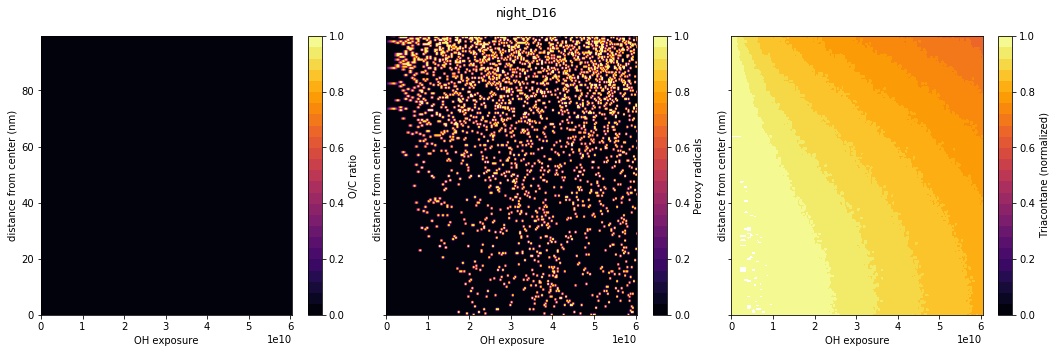

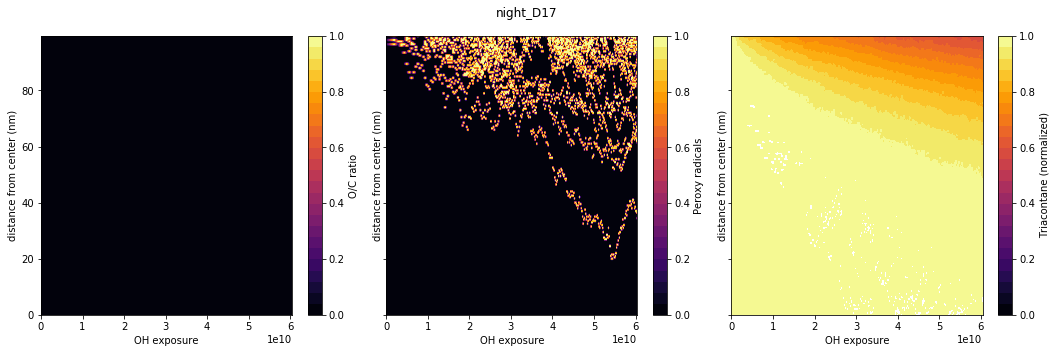

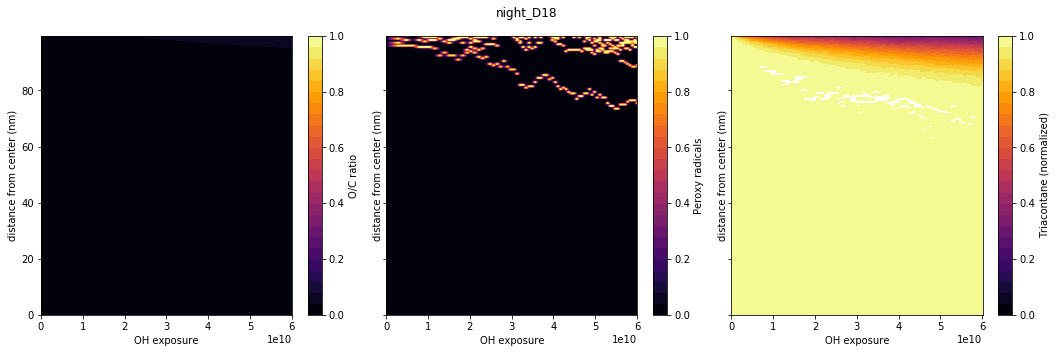

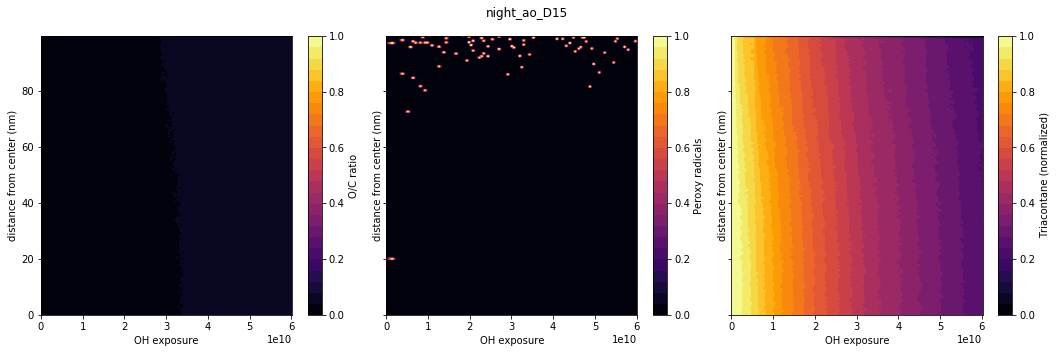

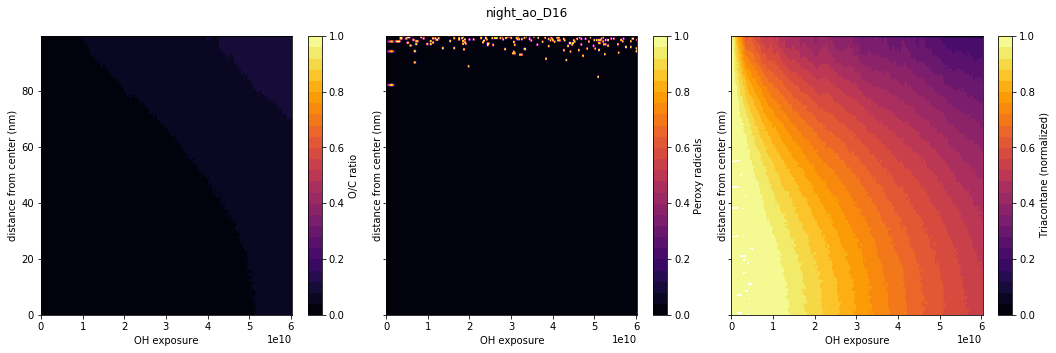

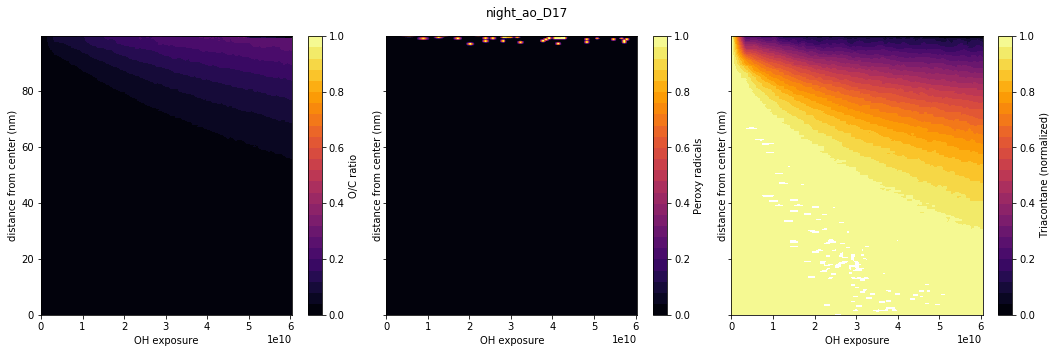

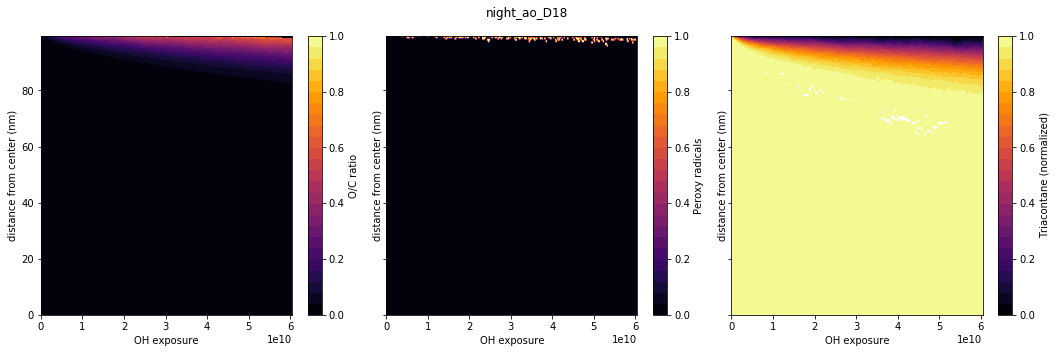

In [5]:
%matplotlib inline
for scenario in natsort.natsorted(files.keys()):
        
    # create reference to save on typing
    simulation = Scenarios[scenario]
    
    # Find OH exposure
    if "day" in scenario:
        OH = 5E6
    else:
        OH = 1E5
    
    OH_exp = OH*simulation.time
    
    # Calculate contour maps for each species
    simulation.calcContourInterpolated("Tri", reverse_axis = True)
    simulation.calcContourInterpolated("OO_sec", reverse_axis = True)
    simulation.calcContourInterpolated("O/C ratio", reverse_axis = True)
    
    # Place data into panel
    
    contour_data = {"Triacontane (normalized)": 
                    simulation.species_contour["Tri"]/simulation.species_contour["Tri"][0,0],
                   "Peroxy radicals": simulation.species_contour["OO_sec"],
                   "O/C ratio": simulation.species_contour["O/C ratio"]}
    
    ScenarioData[scenario+" contours"] = pd.Panel(contour_data, 
                                                  major_axis = simulation.position_int,
                                                 minor_axis = OH_exp)
    
    # Generate plots of contour maps
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey = True)
    
    plt.subplots_adjust(wspace=0.1, hspace=1.75)
    
    fig.suptitle(scenario)
    fig.subplots_adjust(top=0.9)
    
    i = 0
    for species, data in ScenarioData[scenario+" contours"].iteritems():
        
        # Find maximum value on contour and generate contour levels and labels
        #maximum = data.values.max()
        levels = np.linspace(0, 1, num=26)
        labels = np.linspace(0, 1, num=6)
        
        # Create contour map from data frame
        cm = axes[i].contourf(data.columns.values, data.index/1E-7, data, 
                           levels = levels, cmap='inferno')
        
        # Add axis labels
        axes[i].set_xlabel("OH exposure")
        axes[i].set_ylabel("distance from center (nm)")
        
        # Add color bar
        cb = fig.colorbar(cm, ax=axes[i], ticks=labels)
        cb.set_label(species)
        
        i += 1

## Model scenario comparison

To summarize this large data set, several average values are placed in a panel plot comparing diffusion coefficient and oxidant concentration.

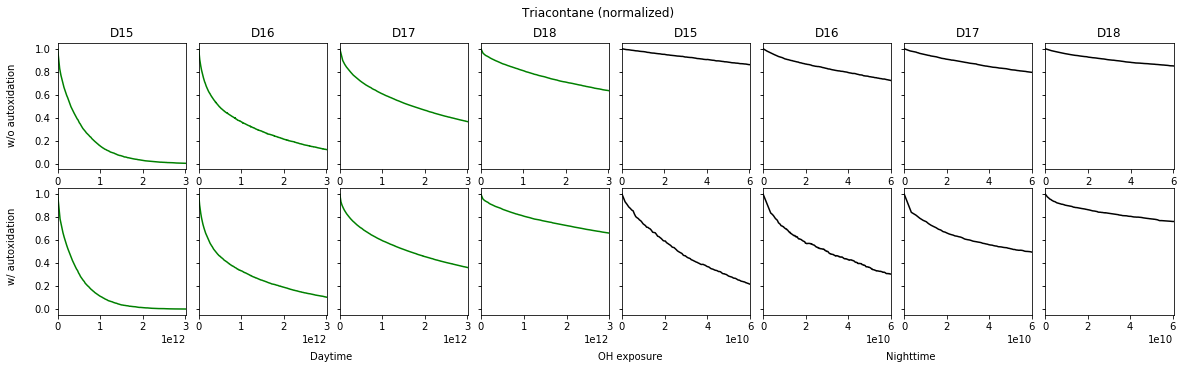

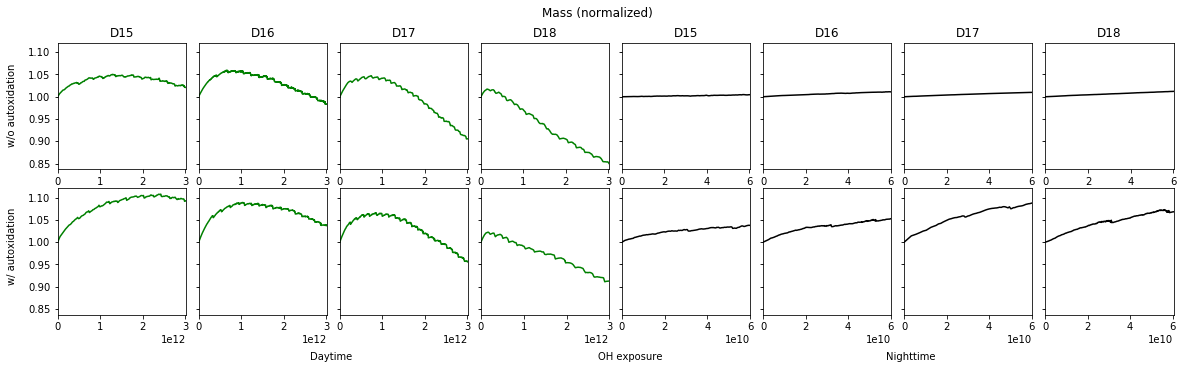

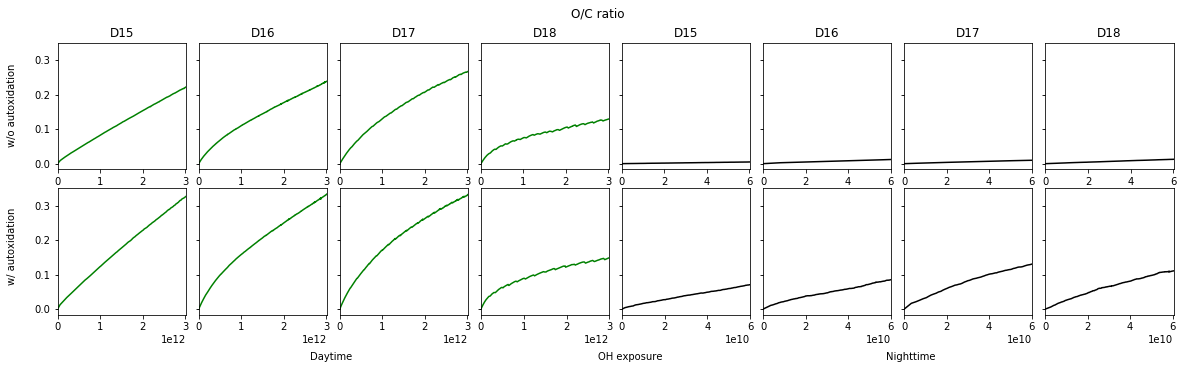

In [17]:
%matplotlib inline

properties = ["Triacontane (normalized)", "Mass (normalized)", "O/C ratio"]

for property in properties:

    fig, axes = plt.subplots(2, 8, figsize=(20, 5), sharex=False, sharey=True)

    fig.suptitle(property)

    plt.subplots_adjust(wspace=0.1, hspace=0.15)
    plt.figtext(0.5, 0, "OH exposure")
    plt.figtext(0.09, 0.8, "w/o autoxidation", rotation='vertical')
    plt.figtext(0.09, 0.4, "w/ autoxidation", rotation='vertical')
    plt.figtext(0.3, 0, "Daytime")
    plt.figtext(0.7, 0, "Nighttime")

    i = 0
    for D in diffusion:
        ScenarioData["day_"+D+" averages"].plot(ax = axes[0, i], legend = False, title = D,
                                                   x = "OH exposure", y = property, color = 'g')
        ScenarioData["day_ao_"+D+" averages"].plot(ax = axes[1, i], legend = False,
                                                   x = "OH exposure", y = property, color = 'g')
        ScenarioData["night_"+D+" averages"].plot(ax = axes[0, i+4], legend = False, title = D,
                                                   x = "OH exposure", y = property, color = 'k')
        ScenarioData["night_ao_"+D+" averages"].plot(ax = axes[1, i+4], legend = False,
                                                   x = "OH exposure", y = property, color = 'k')
        axes[1, i].xaxis.label.set_visible(False)
        axes[1, i+4].xaxis.label.set_visible(False)
        
        i += 1
    property = re.sub("/", " to ", property)
    fig.savefig(property+'_ao.png', fmt='png', dpi=300, bbox_inches='tight')

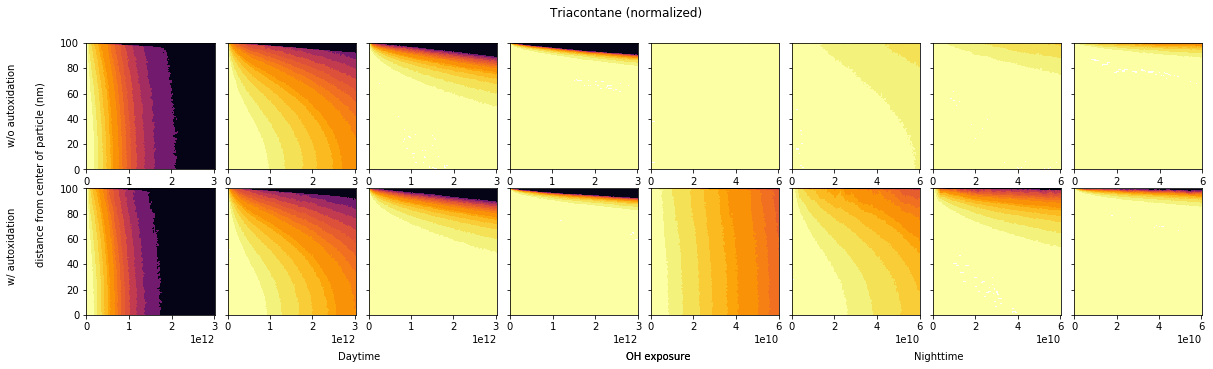

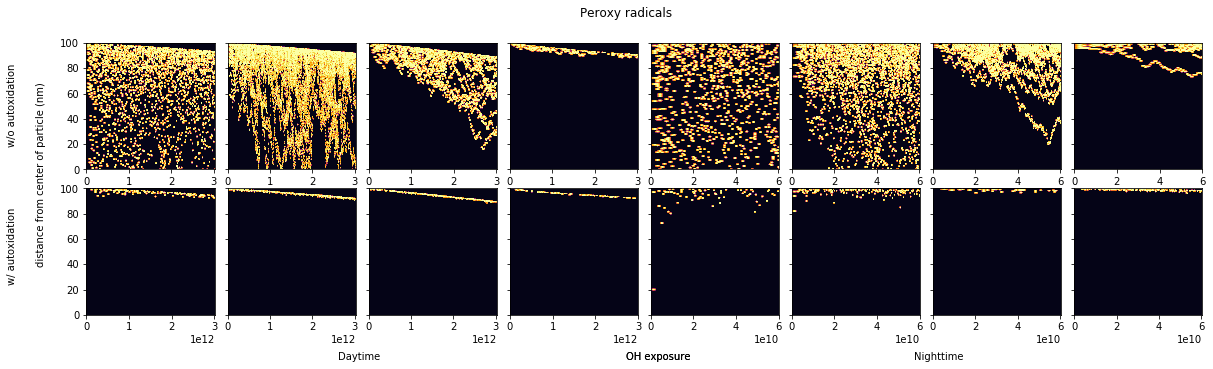

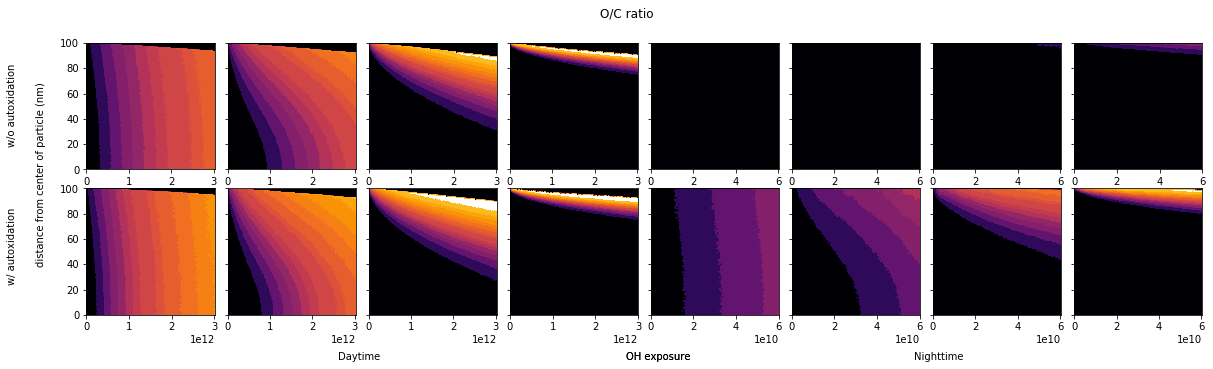

In [9]:
properties = ["Triacontane (normalized)", "Peroxy radicals", "O/C ratio"]

N_levels = 26

levels = np.array([0])
levels = np.append(levels, np.logspace(-4, 0, num=N_levels, base = np.e))
labels = np.logspace(-2, 0, num=6, base = 10)

cmap = mpl.cm.get_cmap('inferno', N_levels)
    
norm = mpl.colors.BoundaryNorm(levels, cmap.N)

for property in properties:

    fig, axes = plt.subplots(2, 8, figsize=(20, 5), sharex=False, sharey=True)

    fig.suptitle(property)

    plt.subplots_adjust(wspace=0.1, hspace=0.15)
    plt.figtext(0.5, 0, "OH exposure")
    plt.figtext(0.07, 0.8, "w/o autoxidation", rotation='vertical')
    plt.figtext(0.07, 0.4, "w/ autoxidation", rotation='vertical')
    plt.figtext(0.3, 0, "Daytime")
    plt.figtext(0.7, 0, "Nighttime")
    plt.figtext(0.5, 0, "OH exposure")
    plt.figtext(0.09, 0.75, "distance from center of particle (nm)", rotation='vertical')
    
    if property == "O/C ratio":
        levels = np.linspace(0, 0.5, num=26)
    else:
        levels = np.linspace(0, 1, num=26)
    labels = np.linspace(0, 1, num=6)
    axes[0, 0].set_ylim([0, 100])
    i = 0
    for D in diffusion:
        data = ScenarioData["day_"+D+" contours"][property]
        cm = axes[0, i].contourf(data.columns.values, data.index/1E-7, data, 
                                   levels = levels, cmap=cmap, norm=norm, spacing='uniform')
        data = ScenarioData["day_ao_"+D+" contours"][property]
        cm = axes[1, i].contourf(data.columns.values, data.index/1E-7, data, 
                                   levels = levels, cmap=cmap, norm=norm, spacing='uniform')
        data = ScenarioData["night_"+D+" contours"][property]
        cm = axes[0, i+4].contourf(data.columns.values, data.index/1E-7, data, 
                                   levels = levels, cmap=cmap, norm=norm, spacing='uniform')
        data = ScenarioData["night_ao_"+D+" contours"][property]
        cm = axes[1, i+4].contourf(data.columns.values, data.index/1E-7, data, 
                                   levels = levels, cmap=cmap, norm=norm, spacing='uniform')
        axes[1, i].xaxis.label.set_visible(False)
        axes[1, i+4].xaxis.label.set_visible(False)
        i += 1
    property = re.sub("/", " to ", property)
    fig.savefig(property+'_ao contour.png', fmt='png', dpi=300, bbox_inches='tight')